In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from TAT import prepare_data, TimeAugmentedTransformer, TimeAugmentedEncoding, PositionalEncoding, MultiHeadAttention
from TAT import FeedForward, EncoderLayer, DecoderLayer, TimeSeriesDataset, train_transformer

from errors import error_df

In [2]:
df = pd.read_csv(r"C:\Users\Varshil\Downloads\super_grid_2022.csv")

In [3]:
df.head()

,Date,Voltage_Avg,ActivePower_Avg,ReActivePower_Avg,Current_Avg,Voltage_Fluctuation,Current_Fluctuation,ActivePower_Fluctuation,ReActivePower_Fluctuation
0,2022-01-01 00:00:00+00:00,33.05,13.93,0.50,239.87,0.00,12.00,0.27,0.00
1,2022-01-01 00:30:00+00:00,33.05,14.20,0.50,241.29,0.07,12.00,0.26,0.00
2,2022-01-01 01:00:00+00:00,32.87,14.34,0.51,249.61,0.20,24.00,1.50,0.13
3,2022-01-01 01:30:00+00:00,33.05,15.04,0.84,257.32,0.21,24.06,0.95,0.27
4,2022-01-01 02:00:00+00:00,33.22,13.87,0.69,233.74,0.47,22.31,1.95,0.76


In [4]:
df.shape

(17520, 9)

In [47]:
train_df = df[df['Date'] < '2022-02-31']
test_df = df[(df['Date'] >= '2022-02-28') & (df['Date'] < '2022-03-15')]

In [49]:
test_df.head(50)

,Date,Voltage_Avg,ActivePower_Avg,ReActivePower_Avg,Current_Avg,Voltage_Fluctuation,Current_Fluctuation,ActivePower_Fluctuation,ReActivePower_Fluctuation
2784,2022-02-28 00:00:00+00:00,33.05,15.00,0.40,259.88,0.21,10.64,0.46,0.87
2785,2022-02-28 00:30:00+00:00,32.89,15.33,0.30,263.00,0.06,0.00,0.60,0.00
2786,2022-02-28 01:00:00+00:00,32.94,15.08,0.30,263.00,0.05,0.00,0.50,0.00
2787,2022-02-28 01:30:00+00:00,32.99,14.96,0.30,259.79,0.08,12.00,0.50,0.00
2788,2022-02-28 02:00:00+00:00,33.11,14.41,0.30,249.25,0.14,7.95,0.61,0.00
2789,2022-02-28 02:30:00+00:00,33.25,13.94,0.30,239.33,0.14,6.12,0.35,0.00
2790,2022-02-28 03:00:00+00:00,33.37,13.45,0.18,229.72,0.09,9.93,0.38,0.70
2791,2022-02-28 03:30:00+00:00,33.24,12.95,-0.39,225.25,0.21,7.62,0.76,0.03
2792,2022-02-28 04:00:00+00:00,33.13,12.60,-0.36,216.34,0.00,3.38,0.06,0.02
2793,2022-02-28 04:30:00+00:00,33.13,12.68,-0.34,216.00,0.00,0.00,0.70,0.02


In [50]:
train_df.shape, test_df.shape

((2832, 9), (720, 9))

In [52]:
# Model parameters
seq_length = 48  # Look at past 48 timesteps look back a 24 hours
prediction_horizon = 1  # Predict next timestep
batch_size = 336 # whole week goes as batch
input_dim = 1  # Single feature (ActivePower_Avg)
output_dim = 1  # Predicting single value

# Prepare data
train_loader, dataset = prepare_data(
    df = train_df,
    target = train_df.ActivePower_Avg,
    seq_length = seq_length,
    prediction_horizon = prediction_horizon,
    batch_size = batch_size
)

# Create model
model = TimeAugmentedTransformer(
    input_dim = input_dim,
    output_dim = output_dim,
    d_model = 64,
    num_heads = 4,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    d_ff = 128,
    dropout = 0.1
)

In [53]:
# Train model
#train_transformer(model, train_loader, num_epochs = 100)

In [54]:
# saved models TAT, TAT2, TAT2_weekly
#torch.save(model, 'TAT2_weekly.pth')
model = TimeAugmentedTransformer(1, 1)
model = torch.load("TAT2_weekly.pth", map_location=torch.device('cpu')) #  Put the model into evaluation mode
model.eval()
print("Loaded")


Loaded


C:\Users\Varshil\AppData\Local\Temp\ipykernel_16660\833102321.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("TAT2_weekly.pth", map_location=torch.de

In [55]:
test_loader, dataset = prepare_data(
    df = test_df,
    target = test_df.ActivePower_Avg,
    seq_length = seq_length,
    prediction_horizon = 1,
    batch_size = batch_size
)

C:\Users\Varshil\SUPERGRID\TAT.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [56]:

tat_pred = []
# Make predictions
model.eval()
with torch.no_grad():
    for _ in range(test_df.shape[0] // batch_size):
        # Get a batch of data
        batch = next(iter(test_loader))

        # Make prediction
        prediction = model(batch['src'], batch['time_values'], batch['tgt'])
        prediction = dataset.inverse_transform(prediction.flatten().reshape(-1, 1))
        tat_pred += list(prediction.flatten())

In [57]:
len(tat_pred)

672

In [42]:
title = {'family': 'serif', 'color':  'darkred', 'weight': 'bold', 'size': 15}
label = {'family': 'sans serif', 'color':  'darkred', 'weight': 'bold', 'size': 16}

In [58]:
test_df['ActivePower_Avg'][:672].shape

(672,)

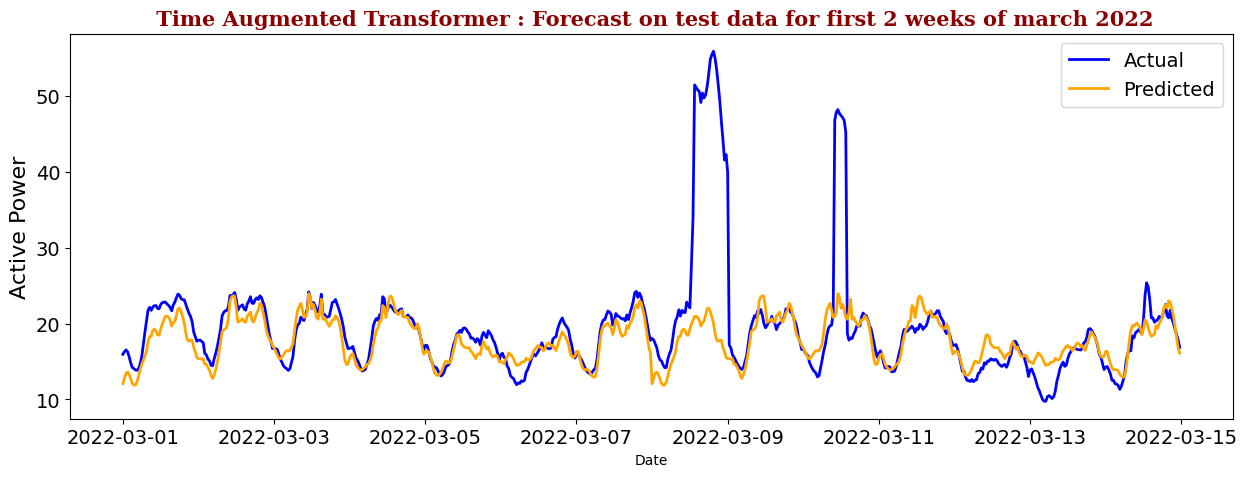

In [65]:
plt.figure(figsize=(15, 5))
plt.title(" Time Augmented Transformer : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'][48:672+48], y=test_df['ActivePower_Avg'][48:672+48], 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'][48:672+48], y=tat_pred, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

In [61]:
len(tat_pred)

672

In [63]:
erros_tat = error_df("TAT", test_df.ActivePower_Avg[48:672+48], np.array(tat_pred))
erros_tat

,model,r2,mse,rmse,mape
0,TAT,0.211172,42.146948,6.492068,10.99


In [17]:
from nn_forecast import NNf, prepare_data, evaluate, TimeSeriesDataset, train, make_sequential_predictions

In [18]:
df_nn = df[df.Date <= "2022-03-15"]
data = np.array(df_nn.ActivePower_Avg)

In [19]:
# Step 1: Prepare data
data_config = prepare_data(
    data=np.array(df_nn.ActivePower_Avg),
    n_lags=48,
    val_size=672,
    test_size=672,
    batch_size=32
)

# Step 2: Initialize model
model = NNf(input_dim=48, hidden_dims=[32, 16])

# Step 3: Train model
train_losses, val_losses = train(
    model = model,
    train_loader = data_config['train_loader'],
    val_loader = data_config['val_loader'],
    epochs=100
)

# Step 4: Evaluate model and make future predictions
results = evaluate(
    model = model,
    test_loader = data_config['test_loader'],
    scaler = data_config['scaler'],
    #last_sequence=data_config['last_sequence'],
    #forecast_horizon=672  # Number of future steps to predict
)

# Access results
ann_pred = results['predictions']
actuals = results['actuals']
metrics = results['metrics']

Epoch 10: Train Loss = 0.0052, Val Loss = 0.0064
Epoch 20: Train Loss = 0.0023, Val Loss = 0.0042
Epoch 30: Train Loss = 0.0013, Val Loss = 0.0042
Epoch 40: Train Loss = 0.0010, Val Loss = 0.0044
Epoch 50: Train Loss = 0.0009, Val Loss = 0.0037
Epoch 60: Train Loss = 0.0008, Val Loss = 0.0030
Epoch 70: Train Loss = 0.0008, Val Loss = 0.0032
Epoch 80: Train Loss = 0.0007, Val Loss = 0.0023
Epoch 90: Train Loss = 0.0008, Val Loss = 0.0022
Epoch 100: Train Loss = 0.0007, Val Loss = 0.0018


In [20]:
!pip install torchsummary

    sys-platform (=="win32") ; extra == 'angle'
                 ~^

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from torchsummary import summary

def model_summary(model, input_size):
    """
    Generate a summary of the model architecture.
    
    Args:
        model: PyTorch model.
        input_size: Tuple representing the size of the input (excluding batch size).
    
    Returns:
        A formatted table summarizing the model architecture.
    """
    print(f"{'=' * 30} Model Summary {'=' * 30}\n")
    summary(model, input_size)
    print(f"\n{'=' * 75}\n")

# Example usage:
# Assuming your model is initialized as `model` and input size is (12,):
model_summary(model, input_size=(48,))

============================== Model Summary ==============================

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           1,568
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
              ReLU-5                   [-1, 16]               0
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 1]              17
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------




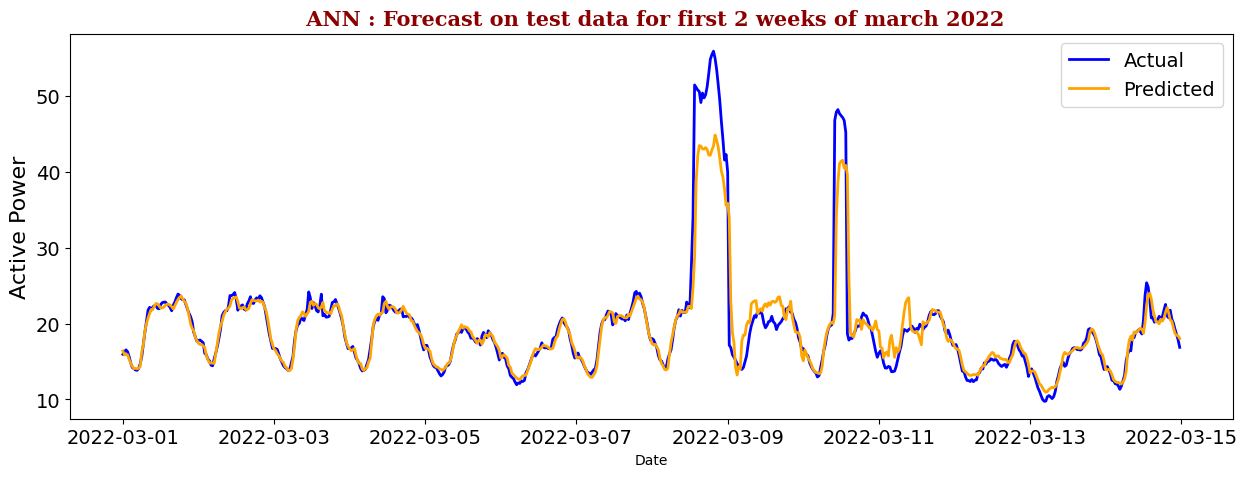

'plt.figure(figsize = (15, 5))\nsns.lineplot(x = test_df.Date, y = test_df.ActivePower_Avg, label=\'Actual\', color = "skyblue")\nsns.lineplot(x = test_df.Date, y = predictions, label=\'Predicted\', color = \'orange\')\nplt.legend()\nplt.title(\'NN Predictions vs Actuals\')'

In [22]:
plt.figure(figsize=(15, 5))
plt.title(" ANN : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'], y=test_df['ActivePower_Avg'], 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'], y=ann_pred, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

"""plt.figure(figsize = (15, 5))
sns.lineplot(x = test_df.Date, y = test_df.ActivePower_Avg, label='Actual', color = "skyblue")
sns.lineplot(x = test_df.Date, y = predictions, label='Predicted', color = 'orange')
plt.legend()
plt.title('NN Predictions vs Actuals')"""

In [23]:
erros_nn = error_df("nn", actuals, ann_pred)

In [24]:
erros_nn

,model,r2,mse,rmse,mape
0,nn,0.865871,7.16649,2.67703,5.04


In [26]:
import json

with open(r"C:\Users\Varshil\Downloads\lstms.json", "r") as json_file:
    # Step 2: Load the data from the file
    data = json.load(json_file)

# Accessing specific elements
lstm_preds = data["preds"] 

In [27]:
bagg = (np.array(tat_pred) * (1 - 0.2138) + np.array(ann_pred) * ( 1 - 0.0517) + np.array(lstm_preds[:-1]) * (1 - 0.0363)) / 3

In [28]:
error_df("bagging TAT & ANN", actuals, bagg)

,model,r2,mse,rmse,mape
0,bagging TAT & ANN,0.654104,18.481173,4.298974,11.61


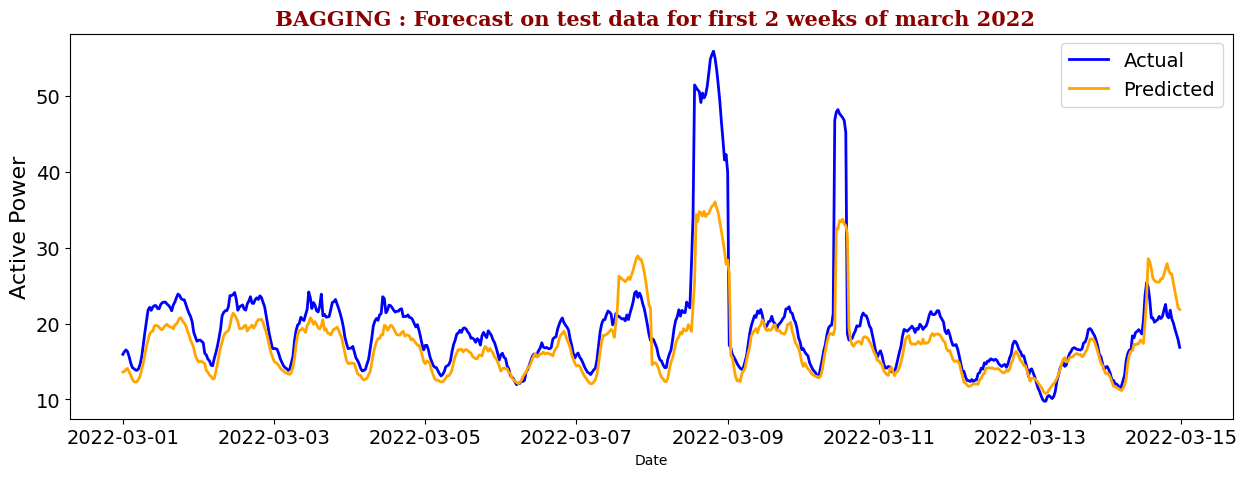

In [29]:
plt.figure(figsize=(15, 5))
plt.title(" BAGGING : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'], y=test_df['ActivePower_Avg'], 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'], y=bagg, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

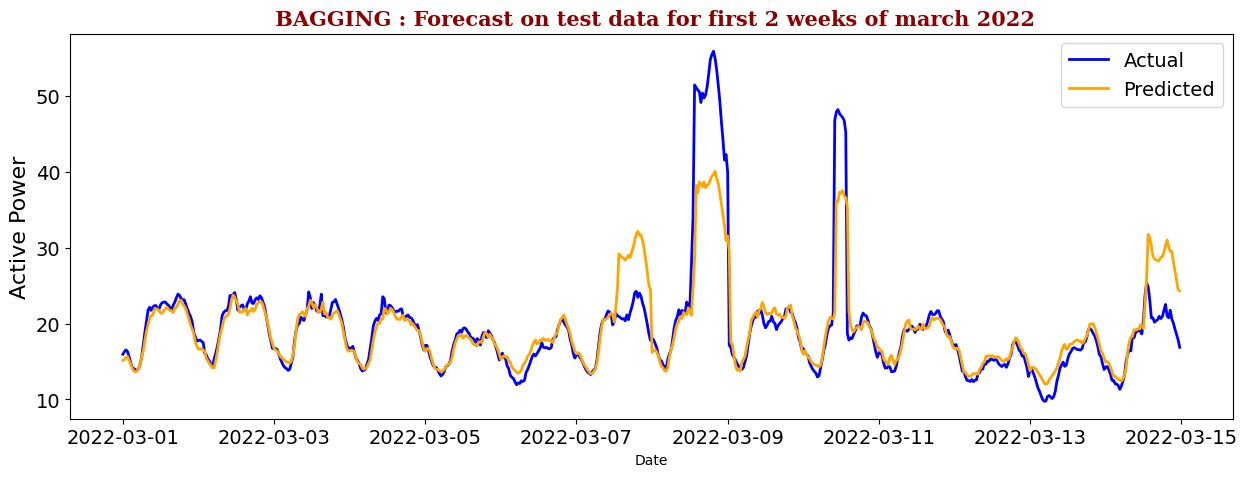

In [30]:

# Calculate weights based on MAPE (lower MAPE -> higher weight)
w_ann = 1 - (5.17 / 100)
w_tat = 1 - (21.38 / 100)
w_lstm = 1 - (3.63 / 100)

# Calculate the final weighted average prediction
weighted_sum = (np.array(ann_pred) * w_ann + np.array(tat_pred) * w_tat + np.array(lstm_preds[:-1]) * w_lstm)
total_weight = (w_ann + w_tat + w_lstm)

# Final ensemble prediction
final_pred = weighted_sum / total_weight

plt.figure(figsize=(15, 5))
plt.title(" BAGGING : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'], y=test_df['ActivePower_Avg'], 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'], y=final_pred, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

In [31]:
error_df("bagging", actuals, final_pred)

,model,r2,mse,rmse,mape
0,bagging,0.74674,13.531643,3.678538,7.83


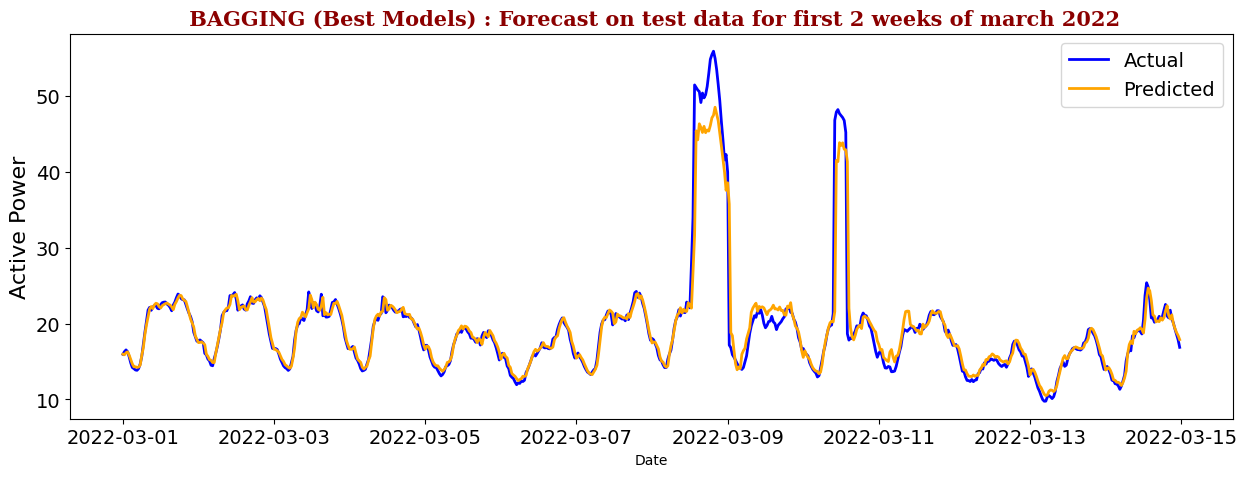

In [33]:

# Calculate weights based on MAPE (lower MAPE -> higher weight)
w_ann = 1 - (5.17 / 100)
w_lstm = 1 - (3.63 / 100)

# Calculate the final weighted average prediction
weighted_sum = (np.array(ann_pred) * w_ann +  np.array(lstm_preds[:-1]) * w_lstm)
total_weight = (w_ann + w_lstm)

# Final ensemble prediction
final_pred = weighted_sum / total_weight

plt.figure(figsize=(15, 5))
plt.title(" BAGGING (Best Models) : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'], y=test_df['ActivePower_Avg'], 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'], y=final_pred, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

In [35]:
error_df("weighted bagging ensemble : best models", actuals , final_pred)

,model,r2,mse,rmse,mape
0,weighted bagging ensemble : best models,0.912333,4.684026,2.164261,4.03
